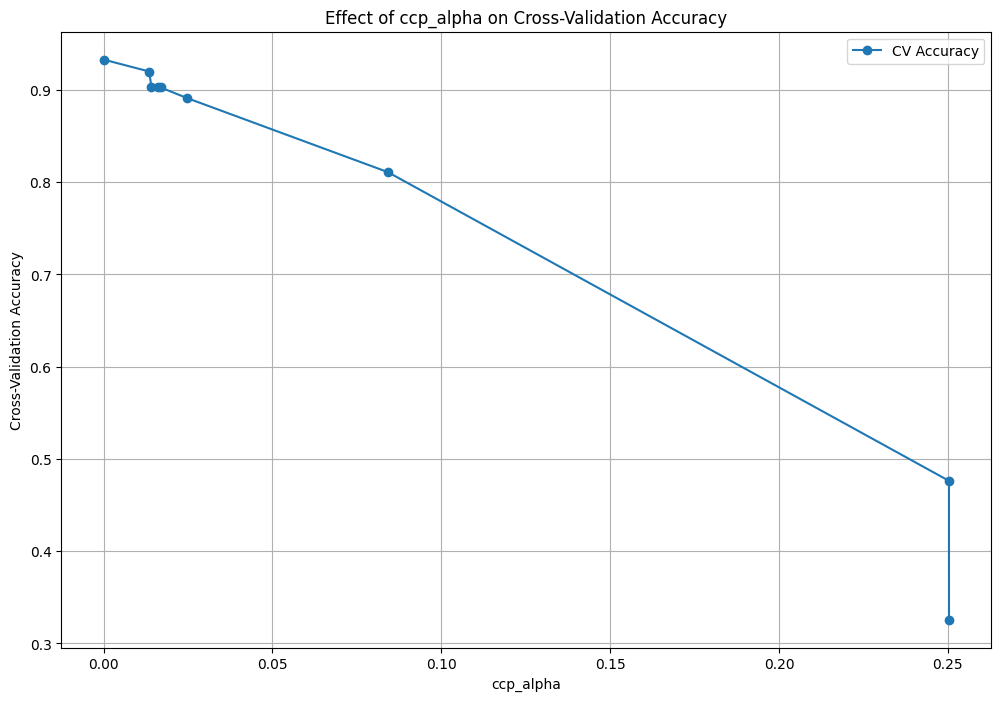

Optimal ccp_alpha: 0.0
Training Accuracy: 93.27%
Testing Accuracy: 93.27%

Classification Report (Testing):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2135
           1       1.00      1.00      1.00      2209
           2       1.00      0.73      0.84      2159
           3       0.78      1.00      0.88      2113

    accuracy                           0.93      8616
   macro avg       0.95      0.93      0.93      8616
weighted avg       0.95      0.93      0.93      8616



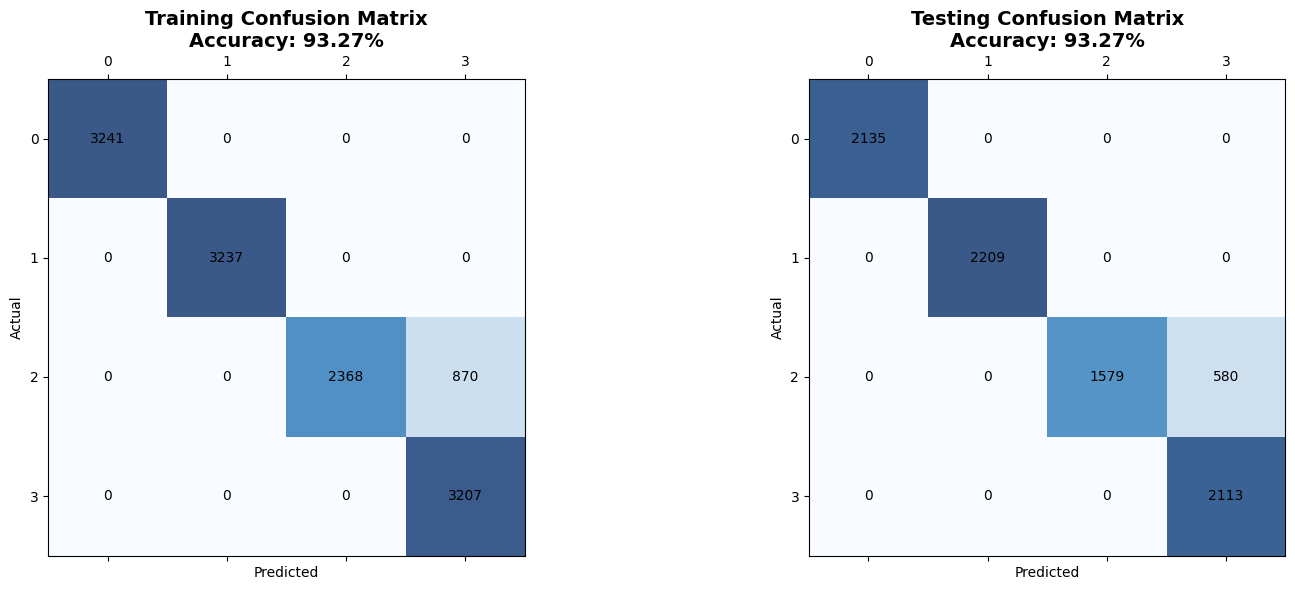

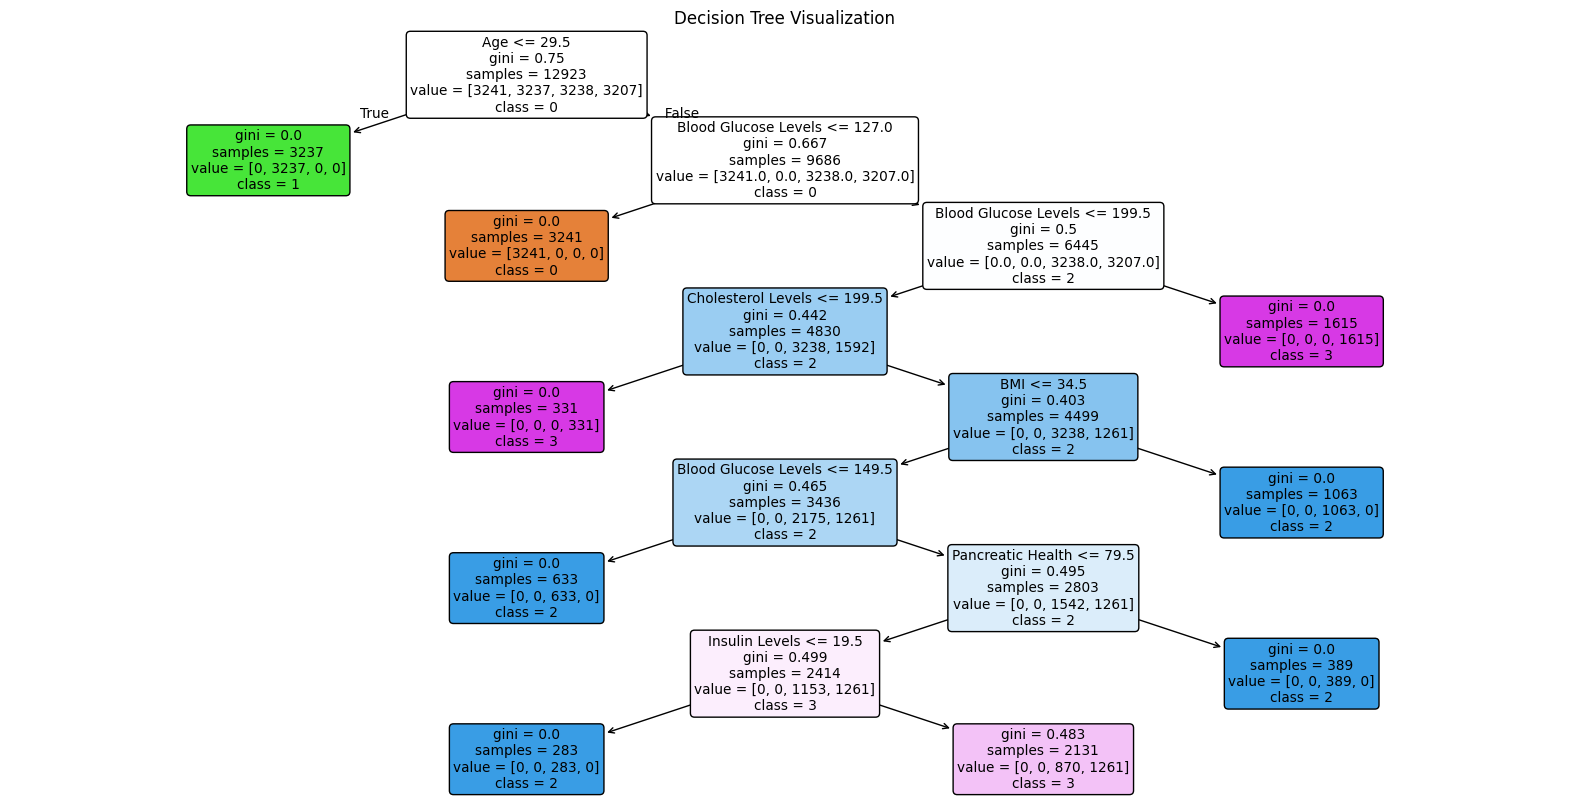

<ipython-input-10-6783867a46d8>:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


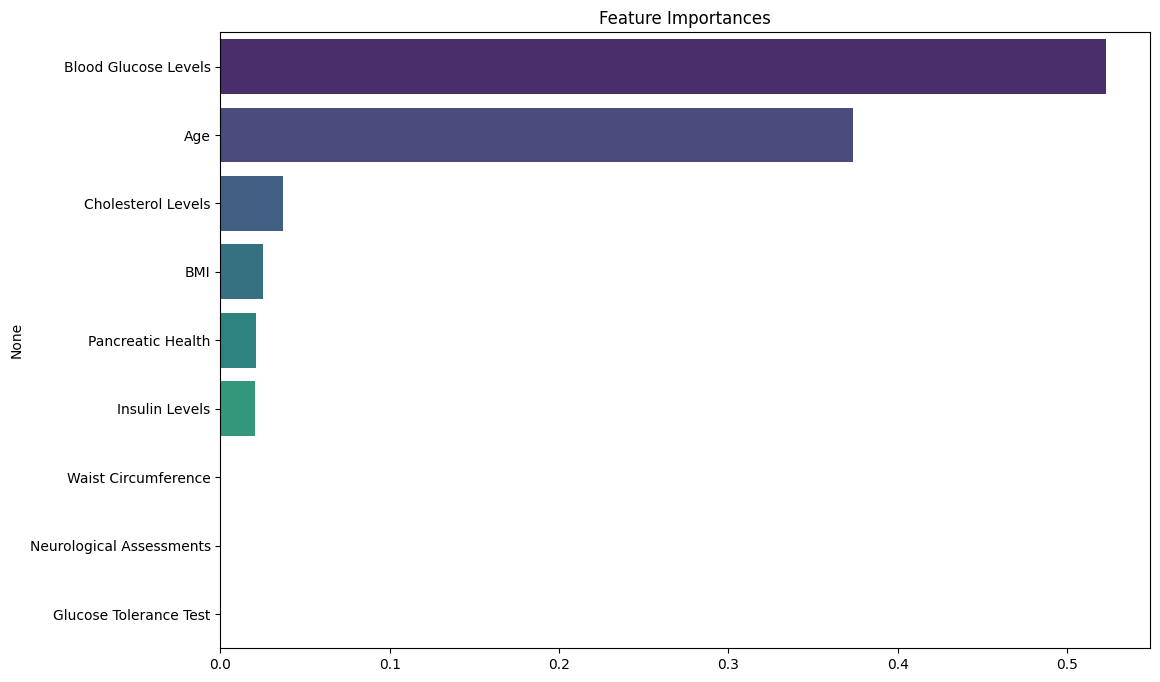

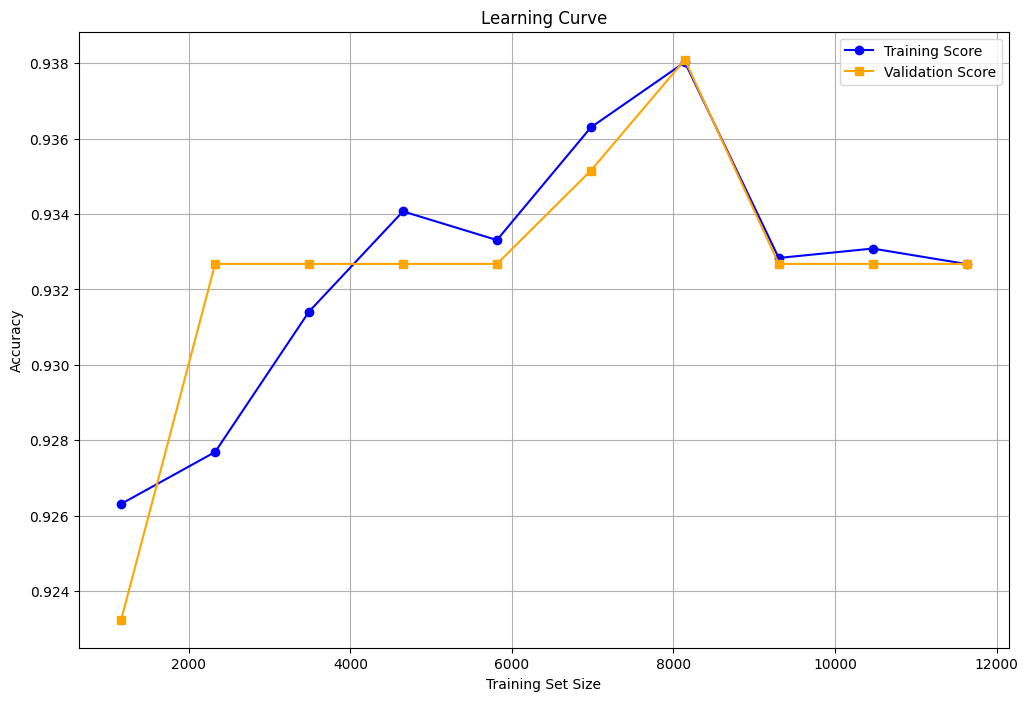

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('data.csv')

# Separate the features and target variable
X = data.drop(columns=['Target'])
y = data['Target']

# Optional: Discretize continuous features like Age
# X['Age_binned'] = pd.cut(X['Age'], bins=[-np.inf, 18, 30, 45, 60, np.inf], labels=['<18', '18-30', '30-45', '45-60', '>60'])
# X = X.drop(columns=['Age'])  # Remove the original Age column to avoid redundancy

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# One-hot encode categorical features (if any exist due to binning or other preprocessing)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns of training and testing sets (to handle possible column mismatches after one-hot encoding)
X_train, X_test = X_train.align(X_test, axis=1, fill_value=0)

# Step 1: Extract effective alphas using cost-complexity pruning path
temp_tree = DecisionTreeClassifier(random_state=42, max_depth=8)  # Set max_depth to 8
temp_tree.fit(X_train, y_train)
path = temp_tree.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

# Step 2: Evaluate performance for each alpha using cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
alpha_scores = []
for alpha in alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha, max_depth=8)
    scores = cross_val_score(pruned_tree, X_train, y_train, cv=cv, scoring='accuracy')
    alpha_scores.append((alpha, np.mean(scores)))

# Analyze results
alpha_results = pd.DataFrame(alpha_scores, columns=['ccp_alpha', 'cv_score'])
optimal_alpha = alpha_results.loc[alpha_results['cv_score'].idxmax(), 'ccp_alpha']

# Plot the alpha vs. CV accuracy
plt.figure(figsize=(12, 8))
plt.plot(alpha_results['ccp_alpha'], alpha_results['cv_score'], marker='o', label='CV Accuracy')
plt.title('Effect of ccp_alpha on Cross-Validation Accuracy')
plt.xlabel('ccp_alpha')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Step 3: Refit the tree with optimal alpha and max_depth=8
final_tree = DecisionTreeClassifier(
    random_state=42,
    ccp_alpha=optimal_alpha,
    max_depth=8,  # Limit tree depth to 8
    min_samples_split=10,  # To balance depth and leaf nodes
    min_samples_leaf=5
)
final_tree.fit(X_train, y_train)

# Step 4: Evaluate performance
y_train_pred = final_tree.predict(X_train)
y_test_pred = final_tree.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Optimal ccp_alpha: {optimal_alpha}")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Accuracy: {test_accuracy:.2%}")
print("\nClassification Report (Testing):")
print(class_report)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
axes[0].matshow(train_conf_matrix, cmap='Blues', alpha=0.8)
for (i, j), val in np.ndenumerate(train_conf_matrix):
    axes[0].text(j, i, f'{val}', ha='center', va='center')
axes[0].set_title(f"Training Confusion Matrix\nAccuracy: {train_accuracy:.2%}", fontsize=14, weight='bold')
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Testing confusion matrix
axes[1].matshow(test_conf_matrix, cmap='Blues', alpha=0.8)
for (i, j), val in np.ndenumerate(test_conf_matrix):
    axes[1].text(j, i, f'{val}', ha='center', va='center')
axes[1].set_title(f"Testing Confusion Matrix\nAccuracy: {test_accuracy:.2%}", fontsize=14, weight='bold')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    final_tree,
    filled=True,
    feature_names=X_train.columns,
    class_names=[str(cls) for cls in np.unique(y)],
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()

# Display feature importances
importances = pd.Series(final_tree.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importances')
plt.show()

# Step 5: Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    final_tree, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange', marker='s')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
